# Estimating MI based on InfoNCE

## Import packages, set GPU and random seeds

import necessary packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import argparse
from torch.autograd import Variable
import itertools
from tqdm import tqdm
from data.mix_gaussian import MixedGaussian
from data.gaussian import Gaussian
from model.utils import *



Use GPU if GPU is available.

In [2]:
cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
torch.set_default_tensor_type(FloatTensor)

Set random seed for reproducity.

In [3]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
## Arguments for running

In [5]:
# arguments
parser = argparse.ArgumentParser()
parser.add_argument("--rho", type=float, default=0.9, help="coefficient of Gaussian")
parser.add_argument("--gamma", type=float, default=1e-5, help="clip the ratio")
parser.add_argument("--d", type=int, default=10, help="dimension of X & Y")
parser.add_argument("--sample_size", type=int, default=1600, help="sample size")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_iters", type=int, default=40000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=100, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-4, help="adam: learning rate")
# parser.add_argument("--latent_dim", type=int, default=1, help="dimensionality of the latent space")
parser.add_argument("--hidden_dim", type=int, default=100, help="Hidden dimension")
parser.add_argument("--alpha", type=float, default=0.99, help="RMSprop: smoothing constant ")
parser.add_argument("--ma_rate", type=float, default=0.1, help="move average rate")
parser.add_argument("--ma_ef", type=float, default=1, help="move average ef")
# parser.add_argument("--confidence", type=float, default=0.005, help="smooth parameter")

# opt = parser.parse_args()
opt, unknown = parser.parse_known_args()

In [6]:
# Decide which kind of distribution to generate; Two choice here: 'Gaussian' and 'MixedGaussian
density = 'Gaussian'

## Define functions and neural networks (NN)

Define the function `generate_data` for generating Gaussian or Mixed Gaussian distributions.

- When generating Gaussian distrition, ${\rm X}$ and ${\rm Y}$ are distributed as 
$$ p_{\rm X \rm Y} = \prod_{i=1}^d \mathcal{N} \left( \mathbf{0}, \begin{bmatrix}1 & \rho \\ \rho & 1\\ \end{bmatrix} \right) $$

- When generating Mixed Gaussian distributions, ${\rm X}$ and ${\rm Y}$ are distributed as 
$$ p_{\rm X \rm Y} = \frac{1}{2} \prod_{i=1}^d \mathcal{N} \left( \mathbf{0}, \begin{bmatrix}1 & \rho \\ \rho & 1\\ \end{bmatrix} \right) + \frac{1}{2} \prod_{i=1}^d \mathcal{N} \left( \mathbf{0}, \begin{bmatrix}1 & {-} \rho \ {-} \rho & 1\\ \end{bmatrix} \right) $$ 

In [7]:
def generate_data(distribution='Gaussian', rho=0.9):
    # rho is the covariance for generating distributions
    # mu1 and mu2 are means for generating Mixed Gaussian distribution 
    mu1 = 0
    mu2 = 0

    # mg is an object of Class Gaussian or MixedGaussian
    if distribution=='Gaussian':
        mg = Gaussian(sample_size=opt.sample_size,rho=rho)
    else:
        mg = MixedGaussian(sample_size=opt.sample_size, mean1=mu1, mean2=mu2,rho1=rho, rho2=-rho)

    # Calculate the ground truth MI between X and Y for (X, Y) from mg
    mi = mg.ground_truth * opt.d

    # Create X, Y for storing generated samples
    X = np.zeros((opt.sample_size,opt.d))
    Y = np.zeros((opt.sample_size,opt.d))

    # Generate samples of random variable X,Y and XY
    for j in range(opt.d):
        # In each iteration, mg.data will generate samples of two dimensions with one dimension for X and another for Y, respectively 
        data = mg.data
        X[:,j] = data[:,0]
        Y[:,j] = data[:,1]        
    X = torch.Tensor(X)
    Y = torch.Tensor(Y)
    XY = torch.cat((X, Y), dim=1)

    return XY, X, Y, mi

Define the neural network.

In [8]:
class Net(nn.Module):
    # Inner class that defines the neural network architecture
    def __init__(self, input_size=2, hidden_size=100, sigma=0.02):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight, std=sigma)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=sigma)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=sigma)
        nn.init.constant_(self.fc3.bias, 0)

    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        # output = F.sigmoid(self.fc3(output))
        output = self.fc3(output)
        return output

Function `_resample` is for resampling the given data samples for training neural network

In [9]:
def _resample(data, batch_size, replace=False):
    # Resample the given data sample.
    index = np.random.choice(
        range(data.shape[0]), size=batch_size, replace=replace)
    batch = data[index]
    return batch

Function `infonce_loss` returns a lower bound of infoNCE loss:
$$l_{infoNCE} ({\rm X}, {\rm Y})= \sup \limits_{f \in \mathcal{F}} \mathbb{E}\left[\log \frac{e^{f({\rm X}, {\rm Y})}}{\mathbb{E} \left[ e^{f({\rm X}, {\rm Y'})} | {\rm X} \right]} \right]$$
where `f()` is implemented by a neural network.


In [10]:
def infonce_loss(net, x_samples, y_samples):
    sample_size = x_samples.shape[0]
    x_tile = x_samples.unsqueeze(0).repeat((sample_size, 1, 1))
    y_tile = y_samples.unsqueeze(1).repeat((1, sample_size, 1))

    T0 = net(torch.cat([x_samples,y_samples], dim = -1))
    T1 = net(torch.cat([x_tile, y_tile], dim = -1))  #[sample_size, sample_size, 1]

    lower_bound = T0.mean() - (T1.logsumexp(dim = 1).mean() - np.log(sample_size))
    return lower_bound

## Generate samples and train the neural network.

In [11]:
discriminator = Net(input_size=opt.d*2, hidden_size=100)
# Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

bcelogit_loss = nn.BCEWithLogitsLoss()  # loss

# move NN model GPU if GPU is available
if cuda:
    discriminator.cuda()

# Adam optimizer
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))


Generate samples and train the neural network.

In [12]:
XY, X, Y, Ground_truth = generate_data(distribution=density, rho=opt.rho)
mi_list = [] # storing the infoNCE of each iteration
for i in range(opt.n_iters):
    data_joint = _resample(XY, batch_size=opt.batch_size)
    train_x = data_joint[:,0:opt.d]
    train_y = data_joint[:,opt.d:]
    
    optimizer_D.zero_grad()
    loss = -infonce_loss(discriminator, train_x, train_y) # negative infonce_loss as the loss
    loss.backward()

    optimizer_D.step()
    mi_list.append(-loss.item())
    if i%500==0:
        print("Iternation: %d, loss: %f"%(i, -loss.item()))

Iternation: 0, loss: -0.000027
Iternation: 500, loss: 2.787301
Iternation: 1000, loss: 4.095554
Iternation: 1500, loss: 4.398554
Iternation: 2000, loss: 4.446631
Iternation: 2500, loss: 4.493898
Iternation: 3000, loss: 4.455656
Iternation: 3500, loss: 4.500001
Iternation: 4000, loss: 4.477431
Iternation: 4500, loss: 4.501705
Iternation: 5000, loss: 4.509816
Iternation: 5500, loss: 4.508554
Iternation: 6000, loss: 4.544929
Iternation: 6500, loss: 4.556558
Iternation: 7000, loss: 4.514485
Iternation: 7500, loss: 4.473107
Iternation: 8000, loss: 4.553349
Iternation: 8500, loss: 4.565469
Iternation: 9000, loss: 4.550261
Iternation: 9500, loss: 4.483590
Iternation: 10000, loss: 4.556413
Iternation: 10500, loss: 4.487988
Iternation: 11000, loss: 4.564132
Iternation: 11500, loss: 4.537271
Iternation: 12000, loss: 4.521422
Iternation: 12500, loss: 4.559649
Iternation: 13000, loss: 4.563319
Iternation: 13500, loss: 4.566533
Iternation: 14000, loss: 4.558338
Iternation: 14500, loss: 4.526571
Ite

## MI estimation and plottings

Use moving average to decide the estimated MI in each iteration in the training

In [13]:
ma_rate = 0.01  # moving average rate
mi_copy = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy[k] = (1-ma_rate) * mi_copy[k-1] + ma_rate * mi_copy[k]


Plot the MI estimation curve against the training iteration, togeter the ground truth.

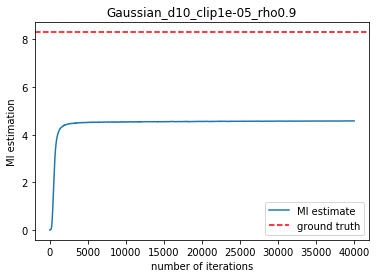

In [14]:
plt.plot(mi_copy, label='MI estimate')
plt.axhline(Ground_truth,label='ground truth',linestyle='--',color='red')
for t in range(len(mi_copy)):
    if (mi_copy[t]>.8*Ground_truth):
        plt.axvline(t,label='80% reached',linestyle=':',color='green')
        break
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.title('{}_d{}_clip{}_rho{}'.format(density, opt.d, opt.gamma, opt.rho))
plt.legend()
# plt.savefig('./results/DIEM/{}_d{}_clip{}_rho{}.pdf'.format(density, opt.d, opt.gamma, opt.rho))
# plt.savefig('./results/DIEM/NoClip{}_d{}_smooth{}_rho{}.pdf'.format(density, opt.d, opt.confidence, opt.rho))

Save the model

In [15]:
torch.save(mi_copy, './InfoNCE{}.pth'.format(opt.sample_size))